# DeepHit for Single Event (Based strongly on https://github.com/havakv/pycox)

In this notebook we show an example of how we can fit a [DeepHit](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit) model when we only have *one* event type.

If you are interested in **competing risks**, see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/deephit_competing_risks.ipynb) instead.

For a more verbose introduction to `pycox` see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In [606]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from sksurv.functions import StepFunction

In [607]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [608]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [609]:
df_train = metabric.read_df().iloc[:100]
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [610]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

We like using the `sklearn_pandas.DataFrameMapper` to make feature mappers.

In [611]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [612]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
In this case `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

DeepHit is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

In [613]:
num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [614]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `num_nodes` output nodes.
We also have batch normalization and dropout between the layers.

In [615]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

We also set `duration_index` which connects the output nodes of the network the the discretization times. This is only useful for prediction and does not affect the training procedure.

DeepHit has a loss that is a combination of a negative log-likelihood and a ranking loss. `alpha` is a parameter that controls the linear combination between the two, and `sigma` is a parameter used by the ranking loss. `alpha = 1` give a loss only containing the negative log-likelihood and `alpha = 0` give a pure ranking loss. Note that this is different than the original paper.

In [616]:
from abc import ABC

import pandas as pd
import torch
import torchtuples as tt
from plotly.figure_factory import np
from pycox.models import DeepHitSingle


class CauseSpecificNet(torch.nn.Module):
    """Network structure similar to the DeepHit paper, but without the residual
    connections (for simplicity).
    """

    def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                 out_features, batch_norm=True, dropout=None):
        super().__init__()
        self.shared_net = tt.practical.MLPVanilla(
            in_features, num_nodes_shared[:-1], in_features,
            batch_norm, dropout,
        )
        self.risk_nets = torch.nn.ModuleList()
        for _ in range(num_risks):
            net = tt.practical.MLPVanilla(
                in_features, num_nodes_indiv, out_features,
                batch_norm, dropout,
            )
            self.risk_nets.append(net)

    def forward(self, x):
        out = self.shared_net(x)
        out = [net(x + out) for net in self.risk_nets]
        out = torch.stack(out, dim=1)
        return out


class CustomDeepHit(DeepHitSingle, ABC):
    def __init__(self, net, optimizer=None, device=None, duration_index=None, alpha=0.2, sigma=0.1, loss=None):
        super().__init__(net, optimizer=optimizer, device=device, duration_index=duration_index, alpha=alpha,
                         sigma=sigma, loss=loss)


    def predict_survival_function(self, X, return_array=False):
        preds = self.predict_surv_df(X.values)
        ret = [StepFunction(x=np.arange(0, preds.shape[0]), y=preds[column].values) for i, column in enumerate(preds)]
        return ret

model = CustomDeepHit(net, optimizer=tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

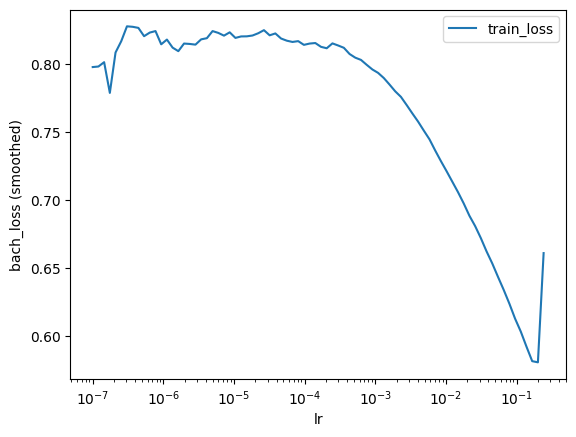

In [617]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [618]:
lr_finder.get_best_lr()

0.020092330025650584

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [619]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [620]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.8346,	val_loss: 0.5100
1:	[0s / 0s],		train_loss: 0.5976,	val_loss: 0.5314
2:	[0s / 0s],		train_loss: 0.5714,	val_loss: 0.5590
3:	[0s / 0s],		train_loss: 0.5441,	val_loss: 0.5845
4:	[0s / 0s],		train_loss: 0.5338,	val_loss: 0.5967
5:	[0s / 0s],		train_loss: 0.4534,	val_loss: 0.6048
6:	[0s / 0s],		train_loss: 0.4097,	val_loss: 0.6088
7:	[0s / 0s],		train_loss: 0.4403,	val_loss: 0.6133
8:	[0s / 0s],		train_loss: 0.3755,	val_loss: 0.6206
9:	[0s / 0s],		train_loss: 0.3728,	val_loss: 0.6297
10:	[0s / 0s],		train_loss: 0.3532,	val_loss: 0.6435


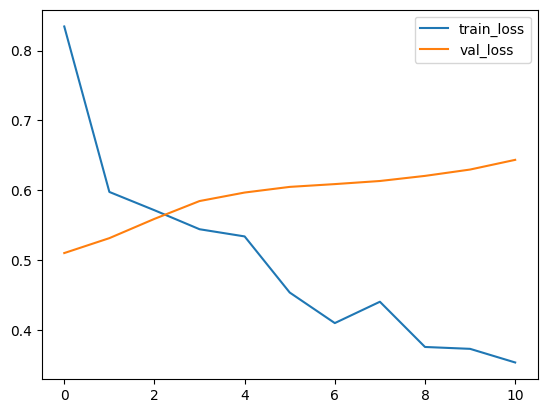

In [621]:
_ = log.plot()

In [622]:
from survshap import SurvivalModelExplainer, PredictSurvSHAP

y_dtype = np.dtype({'names':['event', 'time'], 'formats':[np.uint8, np.uint8]})
y = np.array([tuple(row) for row in np.stack((y_train[1], y_train[0])).transpose(1, 0)], dtype=y_dtype)
model_exp = SurvivalModelExplainer(model, df_train.iloc[:, :9], y)
n_obs = len(x_test)
survshaps = [None for i in range(n_obs)]
for i, obs in enumerate(x_test[:5]):
    xx = pd.DataFrame(np.atleast_2d(obs), columns=df_train.columns[:9].values)
    survshap = PredictSurvSHAP()
    survshap.fit(model_exp, xx)
    survshaps[i] = survshap
    survshap.plot()
    plt.show()

[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.

[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.

[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.

[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.

[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]
[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.

KeyboardInterrupt: 

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [ ]:
surv = model.predict_surv_df(x_test)

We can plot the survival estimates for the first 5 individuals.
Note that the time scale is correct because we have set `model.duration_index` to be the grid points.
We have, however, only defined the survival estimates at the 10 times in our discretization grid, so, the survival estimates is a step function

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

It is, therefore, often beneficial to interpolate the survival estimates, see [this paper](https://arxiv.org/abs/1910.06724) for a discussion.
Linear interpolation (constant density interpolation) can be performed with the `interpolate` method. We also need to choose how many points we want to replace each grid point with. Her we will use 10.

In [ ]:
surv = model.interpolate(10).predict_surv_df(x_test)

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [ ]:
ev.concordance_td('antolini')

#### Brier Score

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times.
Here we just use 100 time-points between the min and max duration in the test set.
Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [ ]:
ev.integrated_brier_score(time_grid)

In [ ]:
ev.integrated_nbll(time_grid)